# Compute MAP

In [1]:
import pandas as pd
import sys, numpy as np
sys.path.append("/afs/cs.stanford.edu/u/anenberg/scr/caffe/python/")
import caffe
import lmdb


# location of the list that was used to create LMDB for training/testing
test_list = '../../data/allFrames/lists/fullpath_shuffle_shotdetect_sampled_5_test_list.txt'

N = 7765 # the number of test examples
num_classes = 101 # the number of classes

# Get the labels from the list

In [2]:
def get_label_from_list(list_filename):
    df = pd.read_csv(list_filename, delimiter= ' ', header = None, names = ['filename', 'class_id'])
    return df

df =  get_label_from_list(test_list)
labels = df.class_id.values
df['video_name'] = df.filename.apply(lambda x: x.split('/')[-2])

# Map the video to the labels

In [3]:
# map the videos to the labels
video_to_labels = list(set(zip(df.video_name, df.class_id)))
video_to_labels = pd.DataFrame(data=[l[1] for l in video_to_labels], index=[l[0] for l in video_to_labels], columns=['true_labels'])

In [4]:
categories = pd.read_csv('/afs/cs.stanford.edu/group/cvgl/rawdata/THUMOS2014/Training/ucfTrainTestlist/classInd.txt', delimiter=' ', header=None, names=['label', 'category'])
categories.label -= 1
categories = {k: v for k, v in zip(categories.label.values, categories.category.values)}

In [5]:
len(video_to_labels)

1553

# Extract features using the extract_features binary

In [6]:
!./extract.sh 

E0308 22:31:34.681560 29587 extract_features.cpp:54] Using GPU
E0308 22:31:34.682071 29587 extract_features.cpp:60] Using Device_id=2
E0308 22:31:35.182682 29587 upgrade_proto.cpp:618] Attempting to upgrade input file specified using deprecated V1LayerParameter: ./model_UCF/quick_train_test.prototxt
F0308 22:31:35.183562 29587 db.hpp:109] Check failed: mdb_status == 0 (2 vs. 0) No such file or directory
*** Check failure stack trace: ***
    @     0x7fd25a49ab7d  google::LogMessage::Fail()
    @     0x7fd25a49cc7f  google::LogMessage::SendToLog()
    @     0x7fd25a49a76c  google::LogMessage::Flush()
    @     0x7fd25a49d51d  google::LogMessageFatal::~LogMessageFatal()
    @     0x7fd25a8e6a59  caffe::db::LMDB::Open()
    @     0x7fd25a825e78  caffe::DataLayer<>::DataLayerSetUp()
    @     0x7fd25a80f736  caffe::BaseDataLayer<>::LayerSetUp()
    @     0x7fd25a80f839  caffe::BasePrefetchingDataLayer<>::LayerSetUp()
    @     0x7fd25a8b041a  caffe::Net<>::Init()
    @     0x7fd25a8b2ca3  

In [12]:
import glob, os
features_dirs = [os.path.basename(x) for x in glob.glob('/afs/cs.stanford.edu/u/anenberg/scr/CS231N/examples/shot_detect_5/extracted/*test*')]

In [18]:
for features_dir in features_dirs:
    print 'working on %s'%features_dir
    try:
        print extract_and_compute_accuracy(features_dir)
    except:
        pass

working on fine_test_features_6000
0.208628461043
working on fine_test_features_7000
0.22408242112
working on fine_test_features_8000
0.204121056021
working on fine_test_features_9000
0.229877656149
working on fine_test_features_10000
0.225370251127
working on fine_test_features_11000


## Open and extract the data from the LMDB

In [15]:
def extract_and_compute_accuracy(features_dir):
    example_dir = '/afs/cs.stanford.edu/u/anenberg/scr/CS231N/examples/shot_detect_5'
    env = lmdb.open(os.path.join(example_dir, 'extracted', features_dir), readonly=True)

    predicted_labels = [] # for a particular image, this will be the argmax for the scores
    data = np.zeros((N, num_classes)) # collect the scores for each image for each class

    with env.begin() as txn:
        with txn.cursor() as cursor:
            for i in range(N):
                key = str(i)
                val = cursor.get(key)
                datum = caffe.proto.caffe_pb2.Datum()
                datum.ParseFromString(val)
                # datum.ListFields()[3][1] contains the scores
                data[i, :] = np.array(list(datum.ListFields()[3][1]))
                predicted_labels.append(np.argmax(np.array(list(datum.ListFields()[3][1]))))

    normalized_data = np.exp(data)/sum(np.exp(data))
    normalized_data = pd.DataFrame(normalized_data)

    normalized_data['video_name'] = df['video_name']
    normalized_data = normalized_data.groupby('video_name').mean()

    normalized_data['predicted_label'] = np.argmax(normalized_data.values, axis = 1)
    normalized_data['true_label'] = video_to_labels
    env.close()

    return np.mean(normalized_data.predicted_label == normalized_data.true_label)

# create the normalized dataframe

## Compute the average precision

In [59]:
dfs = []

def compute_average_precision(normalized_data, class_id):
    # given a class_id compute the average precision for that class
    df = normalized_data[[class_id, 'true_label', 'predicted_label']]
    df = df.sort(class_id, ascending=False)
    df['match'] = (df.true_label == class_id)
    df['precision'] = np.cumsum(df.match)/np.arange(1, len(normalized_data) + 1)
    df['recall'] = np.cumsum(df.match)/np.sum(df.true_label == class_id)
    df['delta_recall'] = np.diff(np.append([0], df.recall.values))
    df['rect_area'] = df['precision'] * df['delta_recall']
    dfs.append(df.copy())
    return sum(df.rect_area)

average_precision = [] # list to hold average_precision

for class_id in range(num_classes):
    ca = compute_average_precision(normalized_data, class_id)
    average_precision.append(ca)
    
average_precision = [x if not np.isnan(x) else 0 for x in average_precision]
labels_as_text = [categories[i] for i in range(num_classes)]

In [60]:
average_precision

[0.45006508895219738,
 0.22864928251238256,
 0.031441542986281865,
 0.20963484277832967,
 0.52956773953282166,
 0.5068467860894218,
 0.46394596891462003,
 0.094328345036353178,
 0.25243452380029208,
 0.58709820562889981,
 0.43531488699517568,
 0.48701978870282653,
 0.17571665196318886,
 0.57247279162479636,
 0.036747889063313596,
 0.48014611982278171,
 0.12161712005839244,
 0.20086997715302218,
 0.20914037619544421,
 0.077489641061084899,
 0.54994506753359385,
 0.4026754887215821,
 0.25694247022495137,
 0.22289838406607615,
 0.42621278501012833,
 0.46102992983136648,
 0.53910412138579433,
 0.36544448969292304,
 0.34070107834159091,
 0.58201449950891937,
 0.37034408764624271,
 0.48481800393400593,
 0.45438696932899569,
 0.10955123426758967,
 0.14600960942592162,
 0.35532098452252359,
 0.11411406589255393,
 0.043945821519612766,
 0.062232958063299808,
 0.1388739879213588,
 0.30274155810177944,
 0.16594253837401188,
 0.071130838865004903,
 0.73203865043797312,
 0.35071512037948005,
 0.035

In [61]:
bar_chart_df = pd.DataFrame(average_precision, columns= ['ap'], index=labels_as_text)
bar_chart_df = bar_chart_df.sort('ap')

Populating the interactive namespace from numpy and matplotlib


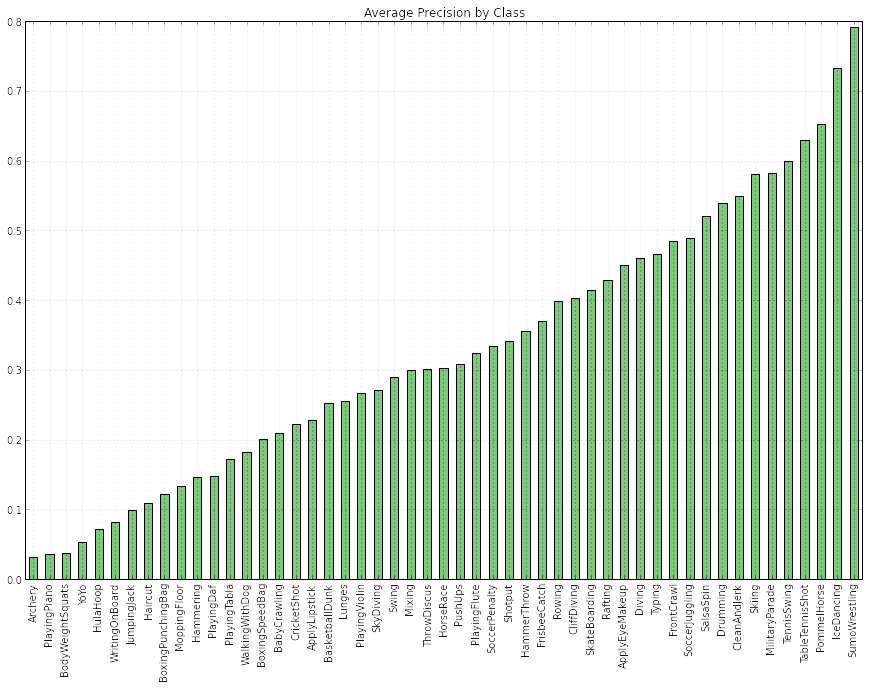

In [62]:
%pylab inline
import matplotlib
bar_chart_df[::2].plot(kind='bar', figsize=(15, 10), legend = False, colormap=matplotlib.cm.Accent, title='Average Precision by Class')

In [63]:
labels_as_text

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'Basketball',
 'BasketballDunk',
 'BenchPress',
 'Biking',
 'Billiards',
 'BlowDryHair',
 'BlowingCandles',
 'BodyWeightSquats',
 'Bowling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'BreastStroke',
 'BrushingTeeth',
 'CleanAndJerk',
 'CliffDiving',
 'CricketBowling',
 'CricketShot',
 'CuttingInKitchen',
 'Diving',
 'Drumming',
 'Fencing',
 'FieldHockeyPenalty',
 'FloorGymnastics',
 'FrisbeeCatch',
 'FrontCrawl',
 'GolfSwing',
 'Haircut',
 'Hammering',
 'HammerThrow',
 'HandstandPushups',
 'HandstandWalking',
 'HeadMassage',
 'HighJump',
 'HorseRace',
 'HorseRiding',
 'HulaHoop',
 'IceDancing',
 'JavelinThrow',
 'JugglingBalls',
 'JumpingJack',
 'JumpRope',
 'Kayaking',
 'Knitting',
 'LongJump',
 'Lunges',
 'MilitaryParade',
 'Mixing',
 'MoppingFloor',
 'Nunchucks',
 'ParallelBars',
 'PizzaTossing',
 'PlayingCello',
 'PlayingDaf',
 'PlayingDhol',
 'PlayingFlute',
 'Play

Populating the interactive namespace from numpy and matplotlib


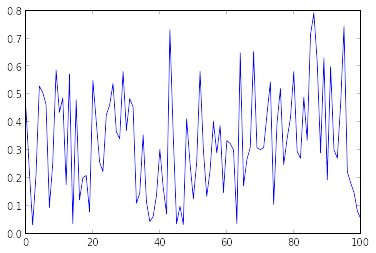

In [64]:
%pylab inline
plt.plot(average_precision)

In [65]:
average_precision[31]

0.48481800393400593

In [66]:
dfs[31]

,31,true_label,predicted_label,match,precision,recall,delta_recall,rect_area
video_name,,,,,,,,
video_test_0000192,6.946207e-05,31,31,True,1.000000,0.0625,0.0625,0.062500
video_test_0000515,1.320594e-06,31,31,True,1.000000,0.1250,0.0625,0.062500
video_test_0001545,3.286011e-07,31,31,True,1.000000,0.1875,0.0625,0.062500
video_test_0000100,2.321974e-08,31,31,True,1.000000,0.2500,0.0625,0.062500
video_test_0000602,1.627539e-08,25,25,False,0.800000,0.2500,0.0000,0.000000
video_test_0000041,1.420592e-08,31,31,True,0.833333,0.3125,0.0625,0.052083
video_test_0000792,1.328524e-08,18,31,False,0.714286,0.3125,0.0000,0.000000
video_test_0000461,7.351318e-09,25,31,False,0.625000,0.3125,0.0000,0.000000
video_test_0000636,1.792187e-09,25,25,False,0.555556,0.3125,0.0000,0.000000


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2499: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


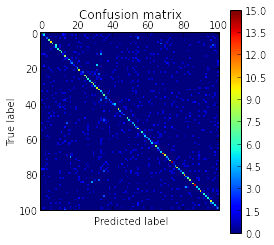

In [67]:
# Create confusion matrix
# Compute confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(normalized_data.true_label, normalized_data.predicted_label)

# Show confusion matrix in a separate window
plt.figure(figsize=(12, 12))
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


#Normalize scores to compute average precision for each class

In [71]:
print 'MAP: %2f'%np.mean(average_precision)

MAP: 0.327939


In [72]:
# What was the accuracy?
np.mean(normalized_data.true_label == normalized_data.predicted_label)

0.33161622665808116

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


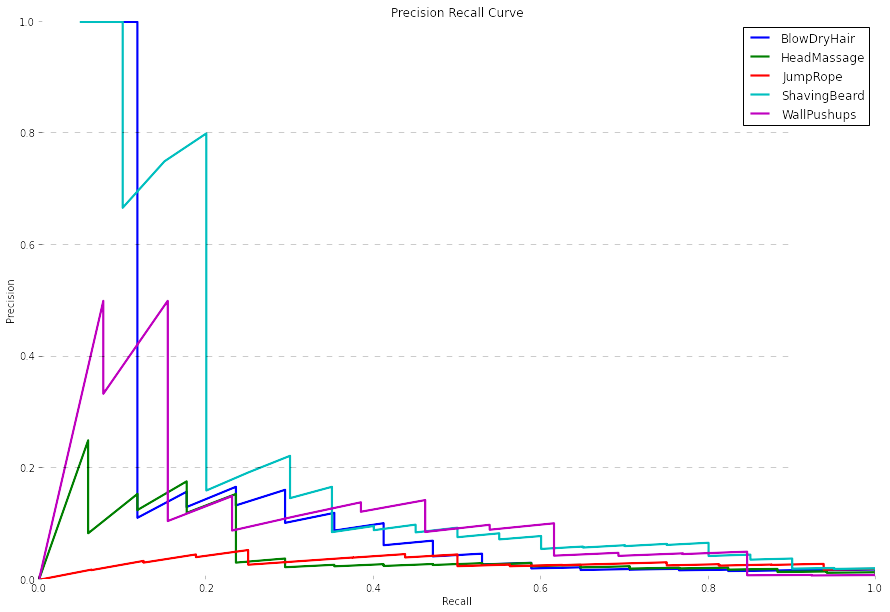

In [70]:
%pylab inline  

# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  
  
# You typically want your plot to be ~1.33x wider than tall. This plot is a rare  
# exception because of the number of lines being plotted on it.  
# Common sizes: (10, 7.5) and (12, 9)  
figure(figsize=(15, 10))  
  
# Remove the plot frame lines. They are unnecessary chartjunk.  
ax = subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False) 

for class_id in [12, 38, 47, 77, 98]:
    ax.plot(dfs[class_id].recall, dfs[class_id].precision, label = categories[class_id], lw=2.5)

    
# Provide tick lines across the plot to help your viewers trace along  
# the axis ticks. Make sure that the lines are light and small so they  
# don't obscure the primary data lines.  
for y in np.arange(0, 1, .2):  
    plot(np.arange(0, 1, 0.1), [y] * len(np.arange(0, 1, 0.1)), "--", lw=0.5, color="black", alpha=0.9)  

# Ensure that the axis ticks only show up on the bottom and left of the plot.  
# Ticks on the right and top of the plot are generally unnecessary chartjunk.  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
ax.legend()

In [81]:
from caffe import draw

ImportError: No module named pydot

In [82]:
!/afs/cs.stanford.edu/u/anenberg/scr/caffe/python/draw_net.py

Traceback (most recent call last):
  File "/afs/cs.stanford.edu/u/anenberg/scr/caffe/python/draw_net.py", line 9, in <module>
    import caffe.draw
  File "/afs/cs.stanford.edu/u/anenberg/scr/caffe/python/caffe/draw.py", line 11, in <module>
    import pydot
ImportError: No module named pydot
